<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00b_How_to_use_numpy_arrays_in_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@gmail.com

## How to work with numpy arrays in fastai: a time series classification example ⏳ 

I'd like to share with you how you can work with numpy arrays in **fastai** through a time series classification example. 

I've used timeseriesAI (based on v1 extensiively). To be able to use fastai v2 I have a few requirements: 


* Use univariate and multivariate time series
* Use labeled (X,y) and unlabeled (X,) datasets
* Data may be already split in train/ valid
* In-memory and on-disk np.arrays (np.memmap in case of larger than RAM data)
* Slice the dataset (based on selected variables and/ or sequence steps)
* Use item and batch tfms
* Create batch with specified output types (TSTensor, TensorCategory, etc)
* Show batch (with tfms)
* Show results
* Add test data and unlabeled datasets
* Export and predict on new data
* Equal or better performance than native Pytorch, fastai v1 & vanilla fastai v2

These are pretty challanging. Let's see if fastai can meet them (with limited customization).

## Import libraries 📚

In [1]:
stable = True # True: latest version, False: stable version

import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if stable: 
        !pip install tsai -q
    else:
        !pip install git+https://github.com/timeseriesAI/tsai.git -q
    
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

     |████████████████████████████████| 204kB 8.0MB/s 
     |████████████████████████████████| 6.8MB 15.1MB/s 
     |████████████████████████████████| 194kB 59.4MB/s 
     |████████████████████████████████| 2.5MB 61.4MB/s 
     |████████████████████████████████| 5.6MB 59.6MB/s 
     |████████████████████████████████| 174kB 66.1MB/s 
     |████████████████████████████████| 92kB 13.9MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 9.5MB 19.5MB/s 
     |████████████████████████████████| 665kB 46.6MB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
ERROR: tensorflow-probability 0.11.0 has requirement cloudpickle==1.3, but you'll have cloudpickle 1.6.0 which is incompatible.
tsai       : 0.2.3
fastai     : 2.1.5
fastcore   : 1.3.2
torch      : 1.7.0+cu101


## Load data 🔢

In [65]:
# dataset id
dsid = 'StarLightCurves'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=False)
X_on_disk, y_on_disk, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)
X_in_memory, y_in_memory, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=False, return_split=False)

Dataset: StarLightCurves
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 

Dataset: StarLightCurves
X      : (9236, 1, 1024)
y      : (9236,)
splits : ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 1

In [3]:
bs = 128
idx = np.random.randint(len(X_in_memory), size=bs)
train_idx = np.random.randint(len(splits[0]), size=bs)
valid_idx = np.random.randint(len(splits[1]), size=bs)

## Building blocks: NumpyTensor/ TSTensor 🧱

Since fastai is based on Pytorch, you'll need to somehow transform the numpy arrays to tensors (NumpyTensor or TSTensor for TS). 

There're transform functions called ToNumpyTensor/ ToTSTensor that transforms an array into a tensor of type NumpyTensor/ TSTensor (both have a show method).

NumpyTensor(shape:(9236, 1, 1024))


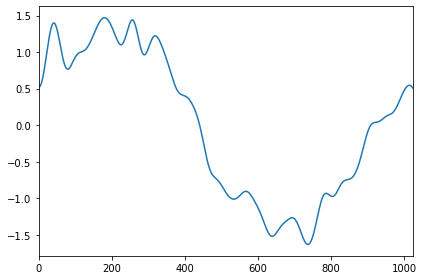

In [4]:
nt = NumpyTensor(X_in_memory)
print(nt)
nt.show();

TSTensor(samples:9236, vars:1, len:1024)


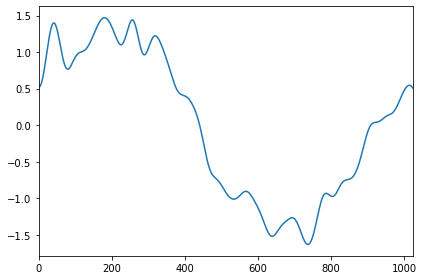

In [5]:
tstensor = TSTensor(X_in_memory)
print(tstensor)
tstensor[0].show();

## Performance benchmarks ⏱

In fastai v2 there are multiple options to create dataloaders. Let's see some of them and most importantly wheteher they meet our requirements.

I will compare performance on 2 processes: 

- cycle_dl: process to cycle through the entire valid dataset (adapted from a function developed by Thomas Capelle (fastai's @tcapelle))
- train model for 25 epochs

### Pytorch dataloader & NumpyDataset

For reference, we'll test performance in the most simple dataset we can have and the native Pytorch dataloader:

In [7]:
valid_ds    = TorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
valid_dl    = torch.utils.data.DataLoader(valid_ds, batch_size=128)
xb, yb = next(iter(valid_dl))
xb, yb

(tensor([[[-0.5697, -0.5679, -0.5659,  ..., -0.5485, -0.5545, -0.5608]],
 
         [[-0.5283, -0.5209, -0.5129,  ..., -0.6006, -0.5799, -0.5563]],
 
         [[ 0.1642,  0.1819,  0.1986,  ...,  0.1773,  0.1694,  0.1617]],
 
         ...,
 
         [[ 0.5924,  0.5822,  0.5737,  ...,  0.6469,  0.6374,  0.6268]],
 
         [[ 0.5427,  0.5495,  0.5557,  ...,  0.4949,  0.4907,  0.4858]],
 
         [[-0.1532, -0.1441, -0.1353,  ..., -0.1930, -0.1855, -0.1781]]]),
 tensor([2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3,
         2, 1, 3, 1, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 1, 3, 3, 2, 1, 1, 3,
         3, 3, 3, 2, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 3, 2, 3, 3, 3, 1, 1, 3,
         2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 1, 3, 1, 3,
         3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 1, 3, 3, 1, 3, 3, 2, 3, 2, 3, 3,
         3, 3, 3, 3, 2, 3, 3, 1]))

In [8]:
%timeit cycle_dl(valid_dl)

10 loops, best of 3: 42.4 ms per loop


In [9]:
%timeit cycle_dl_to_device(valid_dl)

The slowest run took 184.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 57.9 ms per loop


In [10]:
%timeit xb.to(default_device()), yb.to(default_device())

10000 loops, best of 3: 185 µs per loop


This is very fast, but:

* batch is returned on **cpu** (so additional time is required to pass it to gpu). The challanging benchmark is the one in the cycle_dl_to_device(valid_dl) test.
* cannot be easily integrated with fastai.

It will be difficult to find a solution that performs at the same level 😅!

If you want a simple solution that you can use with fastai you will need to use DataLoader (fastai's default dataloader) instead of Pytorch's native dataloader.

In [11]:
train_ds = TSDataset(np.array(X_train), np.array(y_train).astype(int) - 1, types=(TSTensor, TensorCategory))
train_dl = DataLoader(train_ds, bs=128, num_workers=0)
valid_ds = TSDataset(np.array(X_valid), np.array(y_valid).astype(int) - 1, types=(TSTensor, TensorCategory))
valid_dl = DataLoader(valid_ds, bs=128, num_workers=0)
dls      = DataLoaders(train_dl, valid_dl, device=default_device())
xb,yb = next(iter(dls.valid))
print(xb, yb)
print(f'shape: {str(len(train_ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

TSTensor(samples:128, vars:1, len:1024) TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
        1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
        2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 0], device='cuda:0')
shape: 1000         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 852 ms per loop


But this is relatively slow, as DataLoader processes samples one at a time, and each item needs to be casted to the appropriate type.

Note: we'll see how this can accelerated later by processing all batch samples at once.

In [12]:
model = InceptionTime(X_train.shape[-2], dls.c)
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.879922,1.042913,0.577222,00:02
1,0.733451,0.998223,0.577222,00:02
2,0.630715,0.837964,0.849563,00:02
3,0.551137,0.702093,0.803545,00:02
4,0.484976,0.591182,0.805245,00:02
5,0.429435,0.394980,0.855634,00:02
6,0.377575,0.388131,0.854905,00:02
7,0.333722,0.345942,0.855148,00:02
8,0.294618,0.234859,0.940141,00:02
9,0.263707,0.992817,0.548567,00:02


58.110307455062866


### Fastai v1

For comparison, I've run the same exact test in the same machine with fastai v1 timeseries code and these are the timings: : 

- cycle_dl:  1.01s
- training time: 102 s

These are the timings we'd like to beat if we want to have a faster TS framework.

### Fastai v2:  Factory method

Since UCR data was already split into train and test, we'll pass IndexSplitter(splits[1]) as splitter so we get exactly the same split.

In [13]:
dls = TSDataLoaders.from_numpy(X_in_memory, y_in_memory, splitter=IndexSplitter(splits[1]), bs=64, val_bs=128)
next(iter(dls.valid))

(TSTensor(samples:128, vars:1, len:1024), TSTensor(len:128))

In [14]:
%time cycle_dl(dls.train)

CPU times: user 22.1 ms, sys: 56.7 ms, total: 78.8 ms
Wall time: 615 ms


In [15]:
%time cycle_dl(dls.valid)

CPU times: user 78.3 ms, sys: 85.7 ms, total: 164 ms
Wall time: 4.1 s


In [16]:
model = InceptionTime(X_in_memory.shape[-2], dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.761747,1.040834,0.577222,00:06
1,0.614198,0.740359,0.831229,00:05
2,0.522256,0.480806,0.851748,00:05
3,0.447087,0.322034,0.855877,00:05
4,0.380861,0.260046,0.967217,00:05
5,0.326959,0.337902,0.911850,00:06
6,0.280568,0.323265,0.856605,00:06
7,0.237338,0.139302,0.958232,00:05
8,0.202210,0.359641,0.853570,00:05
9,0.179915,0.288338,0.879067,00:05


151.77789187431335


This method is very easy to use, but it's pretty slow.

### Fastai v2:  Datablock API

In [17]:
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock()),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(X_in_memory, y_in_memory)
dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')

shape: 8236         bs: torch.Size([128, 1, 1024])


In [18]:
%time cycle_dl(dls.train)

CPU times: user 518 ms, sys: 247 µs, total: 518 ms
Wall time: 518 ms


In [19]:
%timeit cycle_dl(dls.valid)

1 loop, best of 3: 4.2 s per loop


So it takes > 3 s to cycle the entire dataloader. This is much slower than Pytorch simple model (although fastai v2 provides a lot more functionality!).

In [20]:
model = InceptionTime(X_in_memory.shape[-2], dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.818155,1.109858,0.142909,00:06
1,0.644340,0.816535,0.850656,00:06
2,0.541381,0.475645,0.855027,00:06
3,0.455884,0.533363,0.855391,00:06
4,0.387428,0.929854,0.856362,00:06
5,0.333139,0.255269,0.862190,00:06
6,0.282902,0.346732,0.855270,00:06
7,0.240189,0.273730,0.867290,00:06
8,0.208691,0.137037,0.966124,00:06
9,0.183121,0.215743,0.920835,00:06


161.7985258102417


This is very slow compared to the native Pytorch, and even to fastai v1.

### Mixed Pytorch dataset + Fastai DataLoaders



Sylvain Gugger provided an alternative recommendation to use numpy arrays in this [post](https://forums.fast.ai/t/datablock-with-numpy-input/64848/2):

"You can create a DataLoaders object from regular PyTorch datasets (though all the visualization methods like show_batch and show_results will fail)."

In [54]:
train_ds = TorchDataset(np.array(X_train), np.array(y_train).astype(int) - 1)
valid_ds = TorchDataset(np.array(X_valid), np.array(y_valid).astype(int) - 1)
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128, num_workers=0, device=default_device())
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')

shape: 8236         bs: torch.Size([128, 1, 1024])


In [22]:
%timeit cycle_dl(dls.train)

100 loops, best of 3: 9.43 ms per loop


In [23]:
%timeit cycle_dl(dls.valid)

10 loops, best of 3: 78.8 ms per loop


In [55]:
model = InceptionTime(X_in_memory.shape[-2], len(np.unique(y_in_memory)))
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,1.146022,1.126220,0.142909,00:01
1,0.957017,1.088575,0.142909,00:01
2,0.810698,0.927289,0.753157,00:01
3,0.709833,0.671435,0.808766,00:01
4,0.636209,0.540905,0.838271,00:01
5,0.572345,0.469034,0.833900,00:01
6,0.517191,0.524079,0.848956,00:01
7,0.469836,0.332043,0.859398,00:01
8,0.424776,0.541336,0.856241,00:01
9,0.381872,0.408461,0.856848,00:01


32.74268102645874


This is definitely an improvement in terms of speed.

It is now better than fastai v1! 

## NumpyDatasets & NumpyDataLoaders 🤩

So far we we've seen fastai v2 is very flexible and easy to use, but it's slow compared to v1 (in this example the Datablock API was 65% slower). 

There are at least 3 major differences between vision and time series - TS- (and numpy based data in general) that we can leverage to improve performance: 

1. Vision tipically requires some item preprocessing that is sometimes random. For example, when you randomly crop an image. Each time it'll return a different value. However, with time series, most item transforms are **deterministic** (actually most impact the label only).

2. In vision problems, you usually derive the image and label from a single item (path). In TS problems, it's common to have data already **split between X and y**. It doesn't make much sense to have data already split (into X and y) to merge them in a single item and process them together. 

3. In vision problems, you can only create a batch processing one image at a time. However with numpy datasets, you can create a batch **processing all batch items** at the same time, just by slicing an array/ tensor, which is much faster.

Based on these ideas, we could modify datasets and dataloader and:

1. **Preprocess item tfms in place** during datasets initialization, and thus save this time in every epoch

2. **Apply the tfms independently to the inputs (X) and labels (y)**. The output of this process 2 arrays or tensors that can be easily sliced. Slicing is a much faster operation than applying a transform.

3. Remove the collate function, and instead **slice using all indices at the same time**. Then we can cast the output to the desired subclasses.

To test this approach, I've created a NumpyDatasets and NumpyDataLoader that leverage the characteristics of numpy-based datasets.

BTW, something important as well, is that fastai v2 design allows the use of larger than RAM datasets, as data can be sliced directly from disk before loading in memory. If you want to learn more about the usage of np.memmap you may want to see nb 00.

You can use inplace=True whenever you want to speed up training **and**:

* you are **not using any tfms, or**
* if you are using tfms, **transformed X (and y) both fit in memory**

In any inplace won't be effective for items of type np.memmap (to avoid trying to load in memory larger that RAM datasets).
In many time series problems, X transforms can be applied after a batch has been created. In all this cases, you can use inplace=True.

Inplace=true only impact item transforms.

(TSTensor(vars:1024, len:1024), TensorCategory(2))


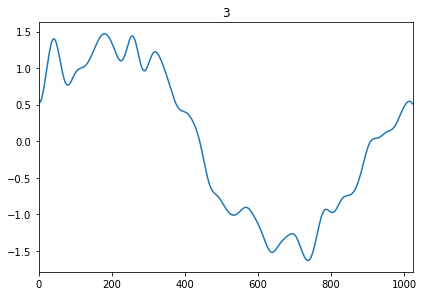

In [66]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, inplace=True)
print(dsets[0])
show_at(dsets, 0);

(TSTensor(vars:1024, len:1024), TensorCategory(2))


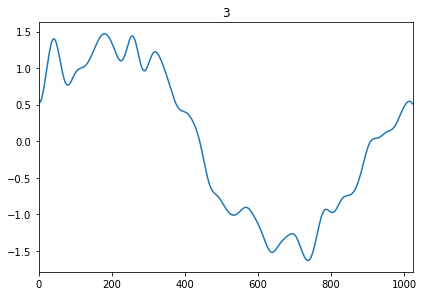

In [67]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, inplace=True)
print(dsets[0])
show_at(dsets, 0);

If you have test data, you can just do this: 

In [68]:
test_ds = dsets.add_test(X_in_memory, y_in_memory)
test_ds[0]

(TSTensor(vars:1024, len:1024), TensorCategory(2))

To create dataloaders, you just need this:

In [69]:
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], num_workers=0)
b = next(iter(dls.train))
b

(TSTensor(samples:64, vars:1, len:1024),
 TensorCategory([1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 0, 1, 2, 1, 1, 1, 2,
         2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0,
         0, 0, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2], device='cuda:0'))

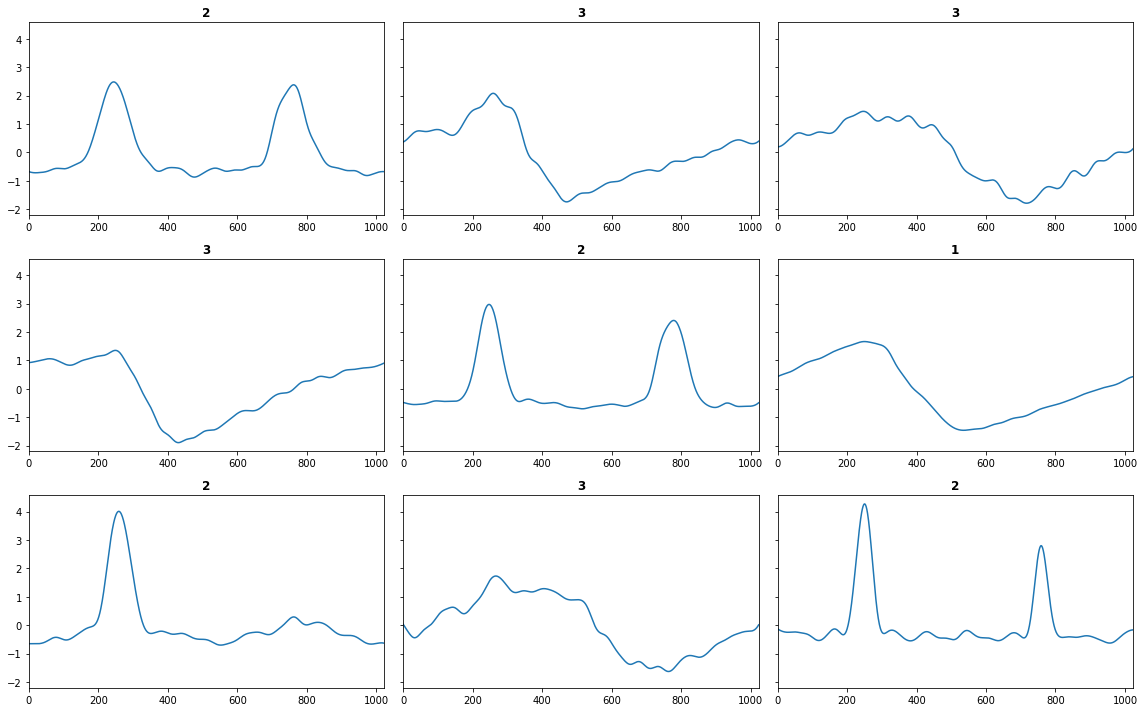

In [70]:
dls.train.show_batch(sharey=True)

Let's now establish another benchmark. 

If we think of it, the fastest and simplest way to create a batch to be used in fastai v2 would be to:

1. split the X and y between train and valid. This can be done at initialization. 

2. Slice the data based on random idx, cast the outputs to the expected classes, and create a tuple. 

This process takes about 200 µs in my machine. So it's very fast.

In [71]:
X_val = X_in_memory[splits[1]]
y_val = y_in_memory[splits[1]].astype(int)
tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([3, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 3, 1, 3, 2, 3, 2, 3, 2, 3, 1, 3, 2, 3,
         3, 1, 3, 1, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 2, 2,
         2, 3, 2, 3, 3, 1, 2, 3, 2, 2, 2, 3, 2, 3, 3, 2, 1, 2, 3, 3, 3, 3, 1, 3,
         3, 1, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3,
         1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3,
         3, 3, 3, 3, 1, 3, 3, 2]))

In [72]:
%timeit tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

The slowest run took 5.40 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 205 µs per loop


Let's see how does this compare to NumpyDatasets when tfms are not preprocessed:

In [73]:
# Preprocess = False
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, inplace=False)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])

In [74]:
valid_ds = dsets.valid
%timeit valid_ds[valid_idx]

100 loops, best of 3: 13.7 ms per loop


In [75]:
%timeit cycle_dl(dls.train)

10 loops, best of 3: 112 ms per loop


In [76]:
%timeit cycle_dl(dls.valid)

1 loop, best of 3: 936 ms per loop


Let's see how is performance when data is preprocessed:

In [77]:
# Preprocess = True
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])

In [78]:
valid_ds = dsets.valid
%timeit valid_ds[valid_idx]

1000 loops, best of 3: 280 µs per loop


😲 Wow! This is superfast! Since we only perform slicing and casting at batch creation time performance is excellent. And it's much faster than when inplace=False. 

In [79]:
%timeit cycle_dl(dls.train)

100 loops, best of 3: 8.59 ms per loop


In [80]:
%timeit cycle_dl(dls.valid)

10 loops, best of 3: 32.4 ms per loop


🙃 This is even faster than the simple Pytorch dataloader, and much more flexible and with many additional benefits ❣️

Let's now measure the timing with data on-disk instead of in memory.

In [81]:
# Preprocess = True
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])

In [82]:
valid_ds = dsets.valid
%timeit valid_ds[valid_idx]

1000 loops, best of 3: 876 µs per loop


In [83]:
%timeit cycle_dl(dls.train)

100 loops, best of 3: 13.2 ms per loop


In [84]:
%timeit cycle_dl(dls.valid)

10 loops, best of 3: 76.8 ms per loop


⚠️ There's a delay in batch creation when data is on disk, but it's not too bad. It shouldn't have much impact during training!



Let's now compare the time to train the model.

In [44]:
# inplace=False, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, inplace=False)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.826911,1.104699,0.142909,00:02
1,0.659175,0.751982,0.789339,00:02
2,0.553355,0.692223,0.630646,00:02
3,0.470298,0.336381,0.910029,00:02
4,0.397659,0.300693,0.891695,00:02
5,0.330179,0.612709,0.853327,00:02
6,0.277986,0.116189,0.970010,00:02
7,0.237663,0.360583,0.897644,00:02
8,0.203334,0.148271,0.970617,00:02
9,0.177842,0.423743,0.804638,00:02


62.11747884750366


⚠️ This NumpyDataLoader is faster than fastai v1 even when inplace=False. 

In [85]:
# inplace=True, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.820441,1.115045,0.010806,00:01
1,0.655222,0.827919,0.814230,00:01
2,0.549788,0.503049,0.854662,00:01
3,0.466577,0.324325,0.856605,00:01
4,0.400969,0.810880,0.794196,00:01
5,0.356731,0.470460,0.856727,00:01
6,0.312526,0.862870,0.856848,00:01
7,0.272707,0.466816,0.855998,00:01
8,0.234627,0.351751,0.857819,00:01
9,0.207302,0.159529,0.963817,00:01


34.36553335189819


🍻 🎉 I think this is a great result. It means that just preprocessing the item transforms can greatly reduce total training time!!

In [46]:
# inplace=True, Data on disk
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.771099,1.033091,0.577222,00:01
1,0.613578,0.734417,0.748907,00:01
2,0.524981,0.470451,0.847863,00:01
3,0.450978,0.372895,0.856241,00:01
4,0.380725,0.394065,0.862676,00:01
5,0.333477,0.640081,0.721345,00:01
6,0.293474,0.382840,0.856848,00:01
7,0.252542,0.376371,0.856605,00:01
8,0.217690,0.221349,0.946090,00:01
9,0.186743,0.145790,0.969524,00:01


36.032233238220215


⚠️ This is also very important, as it means we can now train very large datasets with a good performance without loading data in memory.

## End-to-end process with recommended approach 🏁

Let's simulate an end-to-end process to confirm everything works as expected.

We'll first build the datasets, learner and train a model:

In [96]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)

Dataset: NATOPS
X      : (360, 24, 51)
y      : (360,)
splits : ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179], [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 20

epoch,train_loss,valid_loss,accuracy,time
0,1.931836,1.826247,0.044444,00:00
1,1.826784,1.820590,0.077778,00:00
2,1.667514,1.812019,0.155556,00:00
3,1.490848,1.795290,0.277778,00:00
4,1.321709,1.761513,0.327778,00:00
5,1.173494,1.690534,0.444444,00:00
6,1.055752,1.597438,0.500000,00:00
7,0.956421,1.487419,0.561111,00:00
8,0.875299,1.283058,0.666667,00:00
9,0.800010,1.142327,0.722222,00:00


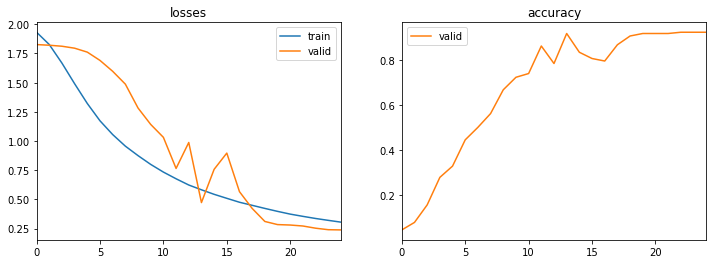

In [97]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()])
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.recorder.plot_metrics()

Let's simulate we need to end the working session now but want to continue working with this datasets and learner in the future. 

To save everything you can use a convenience function I've created that saves the learner with the model, the data and the opt function status: 

In [98]:
learn.save_all()

Learner saved:
path          = 'export'
dls_fname     = 'dls'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


As soon as we've done this, we can end the session, and continue at any time in the future. 

Let's simulate that we need to end the session now:

In [99]:
del learn, dsets, dls

Next time we go back to work, we'll need to reload the datasets and learner (with the same status we had):

In [111]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner', cpu=True)
dls = learn.dls
first(dls.valid)

(TSTensor(samples:128, vars:24, len:51),
 TensorCategory([3, 4, 5, 0, 3, 2, 1, 2, 2, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
         1, 2, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 2, 1, 5, 0, 2, 4, 3,
         2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
         0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 2,
         1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 0, 1, 1, 4, 1, 0, 0, 2, 4, 1,
         0, 3, 4, 3, 1, 2, 2, 2], device='cuda:0'))

We can now analyze the results:

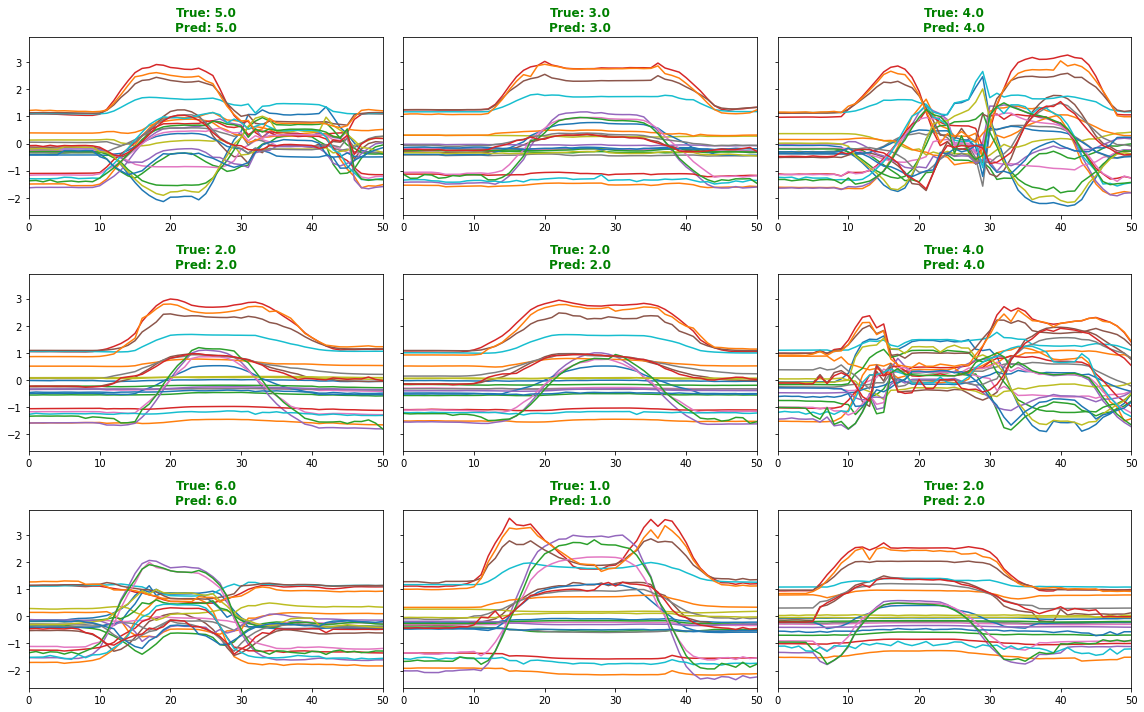

In [112]:
learn.show_results(sharey=True)

In [113]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
valid_probas, valid_targets, valid_preds

(TSTensor(vars:6, len:6),
 TensorCategory([3, 4, 5, 0, 3, 2, 1, 2, 2, 0, 4, 3, 2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5,
         1, 2, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5, 3, 0, 3, 5, 4, 2, 1, 5, 0, 2, 4, 3,
         2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 4, 1, 4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3,
         0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5, 1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 2,
         1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 5, 0, 2, 5, 0, 1, 1, 4, 1, 0, 0, 2, 4, 1,
         0, 3, 4, 3, 1, 2, 2, 2, 2, 0, 4, 0, 0, 1, 3, 4, 4, 2, 1, 1, 1, 4, 4, 3,
         1, 4, 0, 4, 5, 5, 1, 5, 3, 3, 5, 5, 4, 3, 5, 1, 3, 2, 3, 0, 1, 3, 0, 2,
         5, 2, 1, 5, 3, 1, 0, 5, 2, 4, 3, 3]),
 TSTensor(len:180))

We can confirm the learner has the same status it had at the end of training, by confirming the validation accuracy is the same:

In [103]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.9222)

Great! It's the same. This means we have now the learner at the same point where we left it.

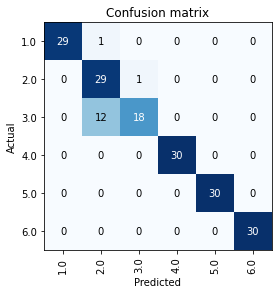

In [104]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Add additional labeled test data

In [114]:
# Labeled test data
test_ds = dls.valid.dataset.add_test(X, y)
test_dl = dls.valid.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:24, len:51),
 TensorCategory([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4, 0, 5, 2, 0, 1, 0, 2, 3,
         3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4, 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4,
         5, 5, 4, 4, 5, 3, 1, 0, 1, 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5,
         2, 0, 2, 3, 0, 5, 1, 0], device='cuda:0'))

In [115]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(TSTensor(vars:6, len:6),
 TensorCategory([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4, 0, 5, 2, 0, 1, 0, 2, 3,
         3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4, 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4,
         5, 5, 4, 4, 5, 3, 1, 0, 1, 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5,
         2, 0, 2, 3, 0, 5, 1, 0, 5, 3, 0, 1, 4, 5, 5, 0, 5, 3, 5, 1, 0, 0, 0, 3,
         0, 5, 5, 2, 1, 5, 5, 2, 4, 4, 0, 1, 1, 4, 1, 2, 2, 4, 1, 3, 5, 3, 4, 1,
         1, 4, 3, 0, 5, 1, 3, 3, 4, 0, 3, 3, 3, 4, 5, 0, 3, 2, 1, 2, 2, 0, 4, 3,
         2, 4, 1, 0, 4, 0, 4, 0, 2, 3, 5, 5, 1, 2, 1, 0, 1, 4, 2, 3, 5, 4, 3, 5,
         3, 0, 3, 5, 4, 2, 1, 5, 0, 2, 4, 3, 2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 4, 1,
         4, 5, 0, 5, 1, 1, 1, 2, 4, 1, 5, 3, 0, 3, 4, 3, 1, 4, 4, 2, 0, 3, 3, 5,
         1, 5, 2, 5, 5, 4, 4, 2, 4, 3, 5, 2, 1, 5, 0, 3, 0, 5, 3, 5, 0, 5, 

### Add additional unlabeled test data

In [116]:
# Unlabeled test data
test_ds = dls.dataset.add_test(X)
test_dl = dls.valid.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:24, len:51),)

In [117]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

TSTensor(vars:6, len:6)

## Conclusions ✅

In summary, we've seen how we can now enjoy all the benefits of v2 when using numpy arrays with a simple scikit-learn-like API, that is much faster than v1. 

The key benefits are: 

* We can easily use numpy arrays (or anything that can be converted into np arrays). For example, this can be used for **univariate and multivariate time series**.
* Easy to use scikit-learn type of API (X, (y))
* We can use both **labeled and unlabeled datasets**
* We can also use **larger than RAM datasets**, keeping data on disk (using np.memmap -see nb 00 for more details-).
* Use item and batch tfms
* Show batch method after tfms have been applied
* Show results after training
* **Easily export** the model to continue at a later time.
* With NumpyDatasets + NumpyDataLoaders batch creation is **100+x faster than fastai v1** and **50+ times faster than vanilla fastai v2** (for numpy arrays).
* This results in **3x faster training** than fastai v1 and **4-5x faster than vanilla fastai v2** (for numpy arrays).